In [1]:
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("pcaMethods")

# if (!requireNamespace("BiocManager", quietly=TRUE)) 
#     install.packages("BiocManager") 

# BiocManager::install("ComplexHeatmap")

In [1]:
.libPaths(R.home('/opt/homebrew/Caskroom/miniforge/base/lib/R/library'))

In [2]:
Output = '/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1015. Fire Sufficient Similarity/P1015.3. Analyses/P1015.3.3. Cluster Analysis/Output'
cur_date = '062425'

library(readxl)
library(tidyverse)
library(reshape2)
library(factoextra)
library(pcaMethods)
library(gridExtra)
library(ggrepel)
library(RColorBrewer)
library(gridtext)
library(IRanges)
library(ComplexHeatmap)
library(circlize)

# reading in file
full_df = data.frame(read_excel("Input/Processed_Data_062425.xlsx")) %>%
    # creating sample ids
    unite("SampleID", c("HAWC_ID", "Sample_Number"), remove = FALSE) 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setd

In [3]:
head(full_df)
dim(full_df)

Sample SampleID  HAWC_ID Study             Sample_Number Class Metric
1 WF     1289909_1 1289909 Trieu et al. 2024 1             Metal Volume
2 WF     1289909_1 1289909 Trieu et al. 2024 1             Metal Volume
3 WF     1289909_1 1289909 Trieu et al. 2024 1             Metal Volume
4 WF     1289909_1 1289909 Trieu et al. 2024 1             Metal Volume
5 WF     1289909_1 1289909 Trieu et al. 2024 1             Metal Volume
6 WF     1289909_1 1289909 Trieu et al. 2024 1             PAH   Volume
  DTXSID        Name       Value     
1 Cr            Chromium   4.32697460
2 Cu            Copper     2.74416110
3 Pb            Lead       2.58496250
4 Ti            Titanium   5.08746284
5 Zn            Zinc       4.52356196
6 DTXSID0023878 Anthracene 0.07867839

[1] 4873   10

This analysis will use PCA to explore if chemical and metal concentrations of control, WS, and WF samples are similar using PCA.

In [4]:
# will run PCA on each class, so the df will be split
split_df = full_df %>%
    # removing outliers
    group_by(Metric) %>%
    group_split

vol_df = split_df[[1]]
weight_df = split_df[[2]]

head(vol_df)

Sample SampleID  HAWC_ID Study             Sample_Number Class Metric
1 WF     1289909_1 1289909 Trieu et al. 2024 1             Metal Volume
2 WF     1289909_1 1289909 Trieu et al. 2024 1             Metal Volume
3 WF     1289909_1 1289909 Trieu et al. 2024 1             Metal Volume
4 WF     1289909_1 1289909 Trieu et al. 2024 1             Metal Volume
5 WF     1289909_1 1289909 Trieu et al. 2024 1             Metal Volume
6 WF     1289909_1 1289909 Trieu et al. 2024 1             PAH   Volume
  DTXSID        Name       Value     
1 Cr            Chromium   4.32697460
2 Cu            Copper     2.74416110
3 Pb            Lead       2.58496250
4 Ti            Titanium   5.08746284
5 Zn            Zinc       4.52356196
6 DTXSID0023878 Anthracene 0.07867839

In [5]:
`%notin%` <- Negate(`%in%`) 

wider_vol_df = vol_df %>%
    select(-c("Name", "Class")) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")

wider_weight_df = weight_df %>%
    select(-c("Name", "Class")) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")

head(wider_vol_df)

Sample HAWC_ID Study                   Sample_Number Metric Cr       
1289909_1 WF     1289909 Trieu et al. 2024       1             Volume  4.326975
1289885_1 WF     1289885 Samsonov et al. 2005    1             Volume 11.451726
1289885_2 WF     1289885 Samsonov et al. 2005    2             Volume 11.288289
1289885_3 WF     1289885 Samsonov et al. 2005    3             Volume 11.688687
1289885_4 WF     1289885 Samsonov et al. 2005    4             Volume 10.104599
1289895_1 WF     1289895 Silberstein et al. 2023 1             Volume  8.063535
          Cu        Pb        Ti        Zn        ⋯ Co        Ni      
1289909_1  2.744161  2.584963  5.087463  4.523562 ⋯ 0.1375035 1.000000
1289885_1 10.102280  9.967226  8.647458 11.502335 ⋯ 8.4136279 7.599473
1289885_2 10.132106  9.231221 12.399011 11.399278 ⋯ 7.2475553 7.719314
1289885_3 11.101081  9.967226 11.036860 11.399278 ⋯ 8.3706874 9.130698
1289885_4 10.672574 10.452241 12.666446 11.773551 ⋯ 7.7879026 8.000536
1289895_1  6.854683  6.765092  8.720251  8.352130 ⋯ 5.1543170 5.221026
          As        Mo       Sr       V         DTXSID5023908 DTXSID9020409
1289909_1  1.539688 2.892434 1.807355 0.7048720  0.04264434    0.01578300  
1289885_1  7.721099 7.238405 7.417853 2.7366721  7.57220046    7.81144616  
1289885_2  7.651052 5.490397 6.703673 2.6390383  7.65074962    7.55828117  
1289885_3 17.375184 7.499846 7.330917 3.6381562 12.36657700   10.70144075  
1289885_4  7.033423 5.357552 6.918863 3.2368377 11.39357067    9.21140453  
1289895_1  2.947277 3.736610 5.523257 0.8208875  0.02856915    0.01435529  
          DTXSID8024153 DTXSID3024289
1289909_1  0.04544297    0.05658353  
1289885_1  9.84817249   14.72497807  
1289885_2  9.65012235   14.29408225  
1289885_3 11.55424474   16.34549934  
1289885_4 10.66008256   15.91234008  
1289895_1  0.02856915    0.01435529

# Principal Component Analysis (PCA)

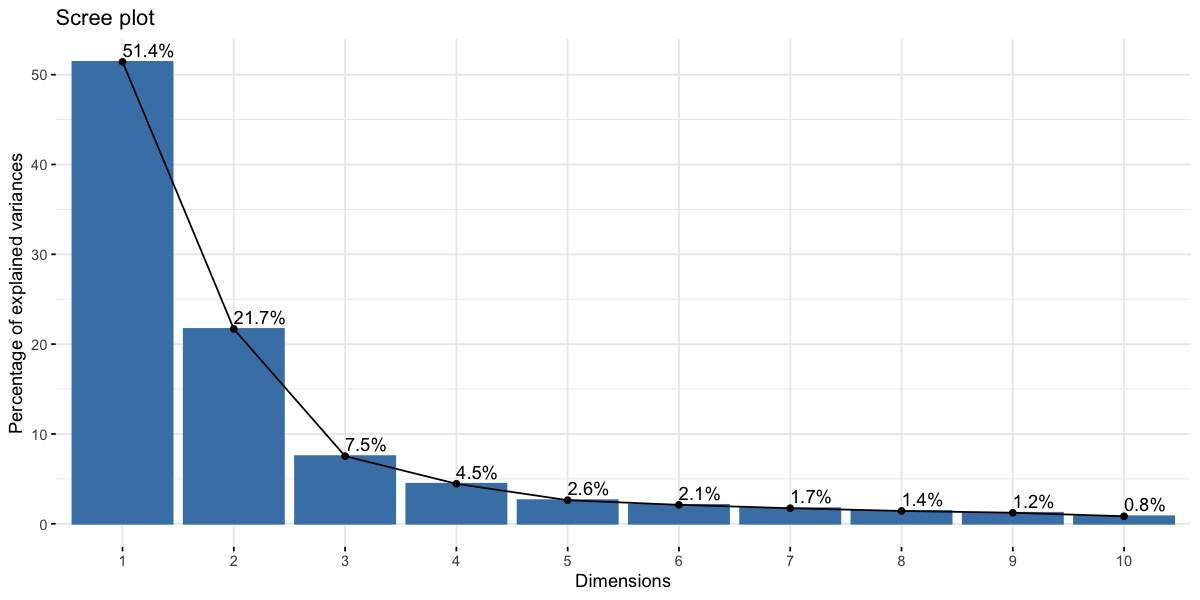

In [6]:
# setting seed for reproducibility
set.seed(12)

# running pca 
vol_pca = prcomp(wider_vol_df[,c(6:ncol(wider_vol_df))], center = TRUE, scale = TRUE)
weight_pca = prcomp(wider_weight_df[,c(6:ncol(wider_weight_df))], center = TRUE, scale = TRUE)

# looking at a scree plot to see how much of the variance was captured in the first 2 eigenvectors
options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(vol_pca, addlabels = TRUE)
fviz_eig(weight_pca, addlabels = TRUE)

The standard way to detect outliers in genetics is the criterion of being “more than 6 standard deviations away from the mean”. [source](https://privefl.github.io/blog/detecting-outlier-samples-in-pca/)

In [7]:
outlier_detection = function(pca_df){
    # """
    # Creating a scoring function for to detect PCA sample outliers. 
    # :param (input): PCA df (df)
    # :output: outlier names
    # """
    
    # getting scores
    scores = pca_df$x
    # identifying samples that are > 6 standard deviations away from the mean
    outlier_indices = apply(scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)
    # getting sample names
    outliers = rownames(scores)[outlier_indices]
    
    return(outliers)
}

# calling fn
vol_outliers = outlier_detection(vol_pca)
weight_outliers = outlier_detection(weight_pca)

In [8]:
# getting length
length(vol_outliers)
length(weight_outliers)

[1] 0

[1] 0

In [9]:
# # also adding in outliers detected from the pca below
# vol_outliers = '1263480_2'
# weight_outliers
# weight_outliers = c(weight_outliers, '1289807_6', '1289807_12', '271638_3', '1285775_1')

In [10]:
# removing those outliers
# removed_wider_vol_df = wider_vol_df[rownames(wider_vol_df) %notin% vol_outliers,]
# removed_wider_weight_df = wider_weight_df[rownames(wider_weight_df) %notin% weight_outliers,]

# dim(removed_wider_vol_df)
# dim(removed_wider_weight_df)

In [11]:
# rerunning pca
# setting seed for reproducibility
# set.seed(12)

# vol_pca = prcomp(removed_wider_vol_df[,c(6:ncol(removed_wider_vol_df))], center = TRUE, scale = TRUE)
# weight_pca = prcomp(removed_wider_weight_df[,c(6:ncol(removed_wider_weight_df))], center = TRUE, scale = TRUE)

# # looking at a scree plot to see how much of the variance was captured in the first 2 eigenvectors
# options(repr.plot.width = 10, repr.plot.height = 5) #changing size
# fviz_eig(vol_pca, addlabels = TRUE)
# fviz_eig(weight_pca, addlabels = TRUE)

In [12]:
# creating 1 df with eigenvectors and metadata
vol_pca_df = data.frame(vol_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID")
weight_pca_df = data.frame(weight_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID") 

more_data_df = rbind(wider_vol_df[,1:5] %>% 
                                    rownames_to_column(var = "SampleID"), 
                         wider_weight_df[,1:5] %>% 
                                    rownames_to_column(var = "SampleID")) 

full_eigenvector_df = inner_join(rbind(vol_pca_df, weight_pca_df), 
                                             more_data_df) %>%
    # cleaning variable names here
    mutate(Sample = ifelse(Sample == "WS", "Woodsmoke",
                                  ifelse(Sample == "WF", "Wildfire", Sample)))

head(full_eigenvector_df)

Joining with `by = join_by(SampleID)`


SampleID  PC1       PC2        Sample   HAWC_ID Study                  
1 1289909_1 -7.204036  2.3342195 Wildfire 1289909 Trieu et al. 2024      
2 1289885_1  2.464713 -0.6427535 Wildfire 1289885 Samsonov et al. 2005   
3 1289885_2  2.157786 -0.5828411 Wildfire 1289885 Samsonov et al. 2005   
4 1289885_3  4.134949 -0.2962230 Wildfire 1289885 Samsonov et al. 2005   
5 1289885_4  2.949724  0.1162659 Wildfire 1289885 Samsonov et al. 2005   
6 1289895_1 -3.695183 -1.3311686 Wildfire 1289895 Silberstein et al. 2023
  Sample_Number Metric
1 1             Volume
2 1             Volume
3 2             Volume
4 3             Volume
5 4             Volume
6 1             Volume

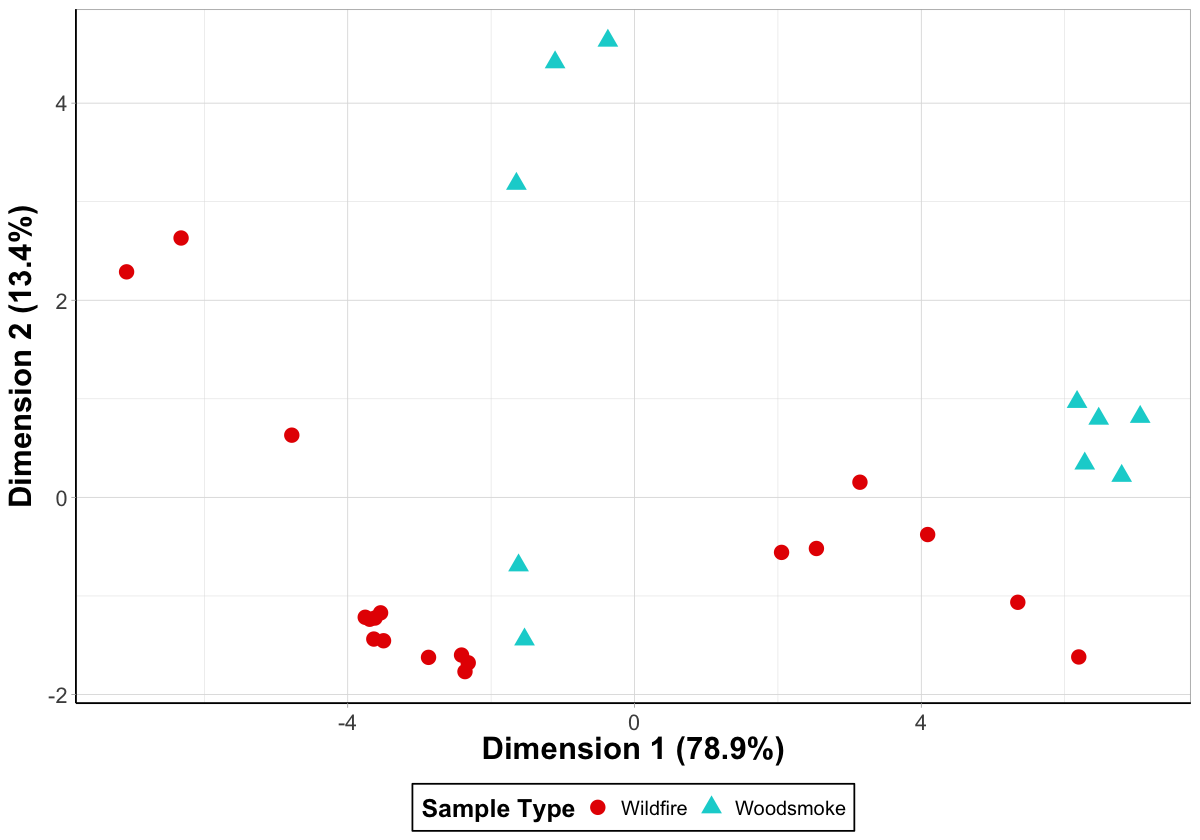

In [13]:
options(repr.plot.width=10, repr.plot.height=7) #changing size
vol_pca_figure = ggplot() + 
  geom_point(data = full_eigenvector_df %>%
           filter(Metric == 'Volume'), aes(x = PC1, y = PC2, color = Sample, shape = Sample),
             size = 4, position = position_jitter(w = 0.2, h = 0.2), alpha = 1) + 
  # geom_text_repel(data = full_eigenvector_df %>%
  #          filter(Metric == 'Volume', PC1 > 5), 
  #                 aes(x = PC1, y = PC2, color = Sample, label = SampleID), 
  #                 segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.3) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1 (78.9%)', y = 'Dimension 2 (13.4%)', #changing axis labels 
       color = "Sample Type", shape = "Sample Type") + #changing legend title

  scale_color_manual(values = c('#e60000', '#00d2d2'))

vol_pca_figure

In [14]:
weight_pca_figure = ggplot(data = full_eigenvector_df %>%
           filter(Metric == 'Weight'), 
       aes(x = PC1, y = PC2, color = Sample, shape = Sample)) + 
  geom_point(size = 4, position = position_jitter(w = 0.08)) + 
  # geom_text_repel(data = full_eigenvector_df %>%
  #          filter(Metric == 'Weight', PC1 < -10), 
  #                 aes(x = PC1, y = PC2, color = Sample, label = SampleID), 
  #                 segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.3) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1 (51.4%)', y = 'Dimension 2 (21.7%)', #changing axis labels 
       color = "Sample Type", shape = "Sample Type") + #changing legend title

  scale_color_manual(values = c('#e60000', '#00d2d2'))

weight_pca_figure

# Heatmaps

In [15]:
annotation_vol_col_df = unique(vol_df[,c("Class", "Name")]) %>%
    column_to_rownames(var = "Name")
annotation_vol_row_df = unique(vol_df[,c("SampleID", "Sample")]) %>%
    # removing outliers
    filter(SampleID %notin% vol_outliers) %>%
    column_to_rownames(var = "SampleID") %>%
     mutate(Sample = ifelse(Sample == "WS", "Woodsmoke",
                                  ifelse(Sample == "WF", "Wildfire", Sample)))
annotation_weight_col_df = unique(weight_df[,c("Class", "Name")]) %>%
    column_to_rownames(var = "Name")
annotation_weight_row_df = unique(weight_df[,c("SampleID", "Sample")]) %>%
    # removing outliers
    filter(SampleID %notin% weight_outliers) %>%
    column_to_rownames(var = "SampleID") %>%
     mutate(Sample = ifelse(Sample == "WS", "Woodsmoke",
                                  ifelse(Sample == "WF", "Wildfire", Sample)))

head(annotation_vol_col_df)
head(annotation_vol_row_df)

Class
Chromium   Metal
Copper     Metal
Lead       Metal
Titanium   Metal
Zinc       Metal
Anthracene PAH

Sample  
1289909_1 Wildfire
1289885_1 Wildfire
1289885_2 Wildfire
1289885_3 Wildfire
1289885_4 Wildfire
1289895_1 Wildfire

In [17]:
# obtaining color palette
fall_colors = rev(palette(hcl.colors(10, "PiYG")))

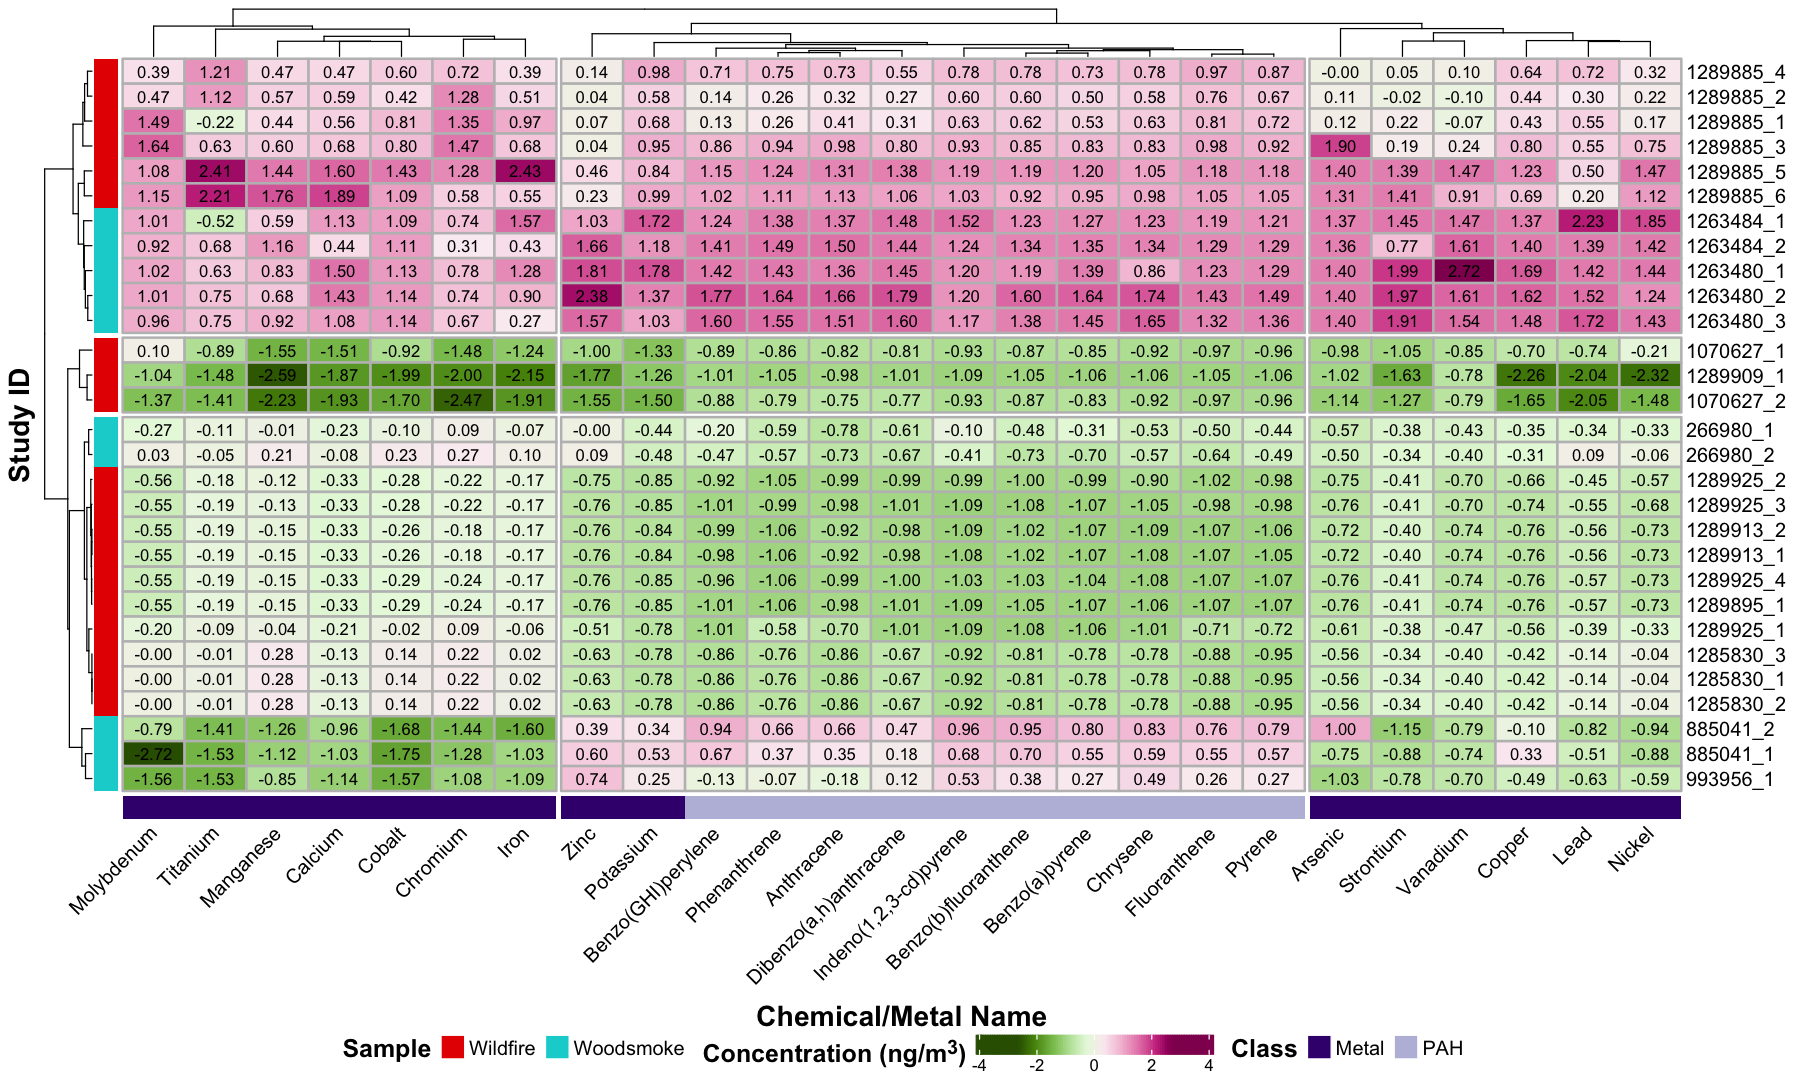

In [18]:
options(repr.plot.width=15, repr.plot.height=9) #changing size

wider_vol_df = vol_df %>%
    select(-c("DTXSID", "Class")) %>%
    # removing outliers
    filter(SampleID %notin% vol_outliers) %>%
    pivot_wider(names_from = "Name", values_from = "Value") %>%
    column_to_rownames(var = "SampleID") 

vol_map = Heatmap(scale(wider_vol_df[,6:ncol(wider_vol_df)]), rect_gp = gpar(col = "gray", lwd = 2), # cell border color
         # legend title
         heatmap_legend_param = list(title = gt_render("Concentration (ng/m<sup>3</sup>)"), 
                      title_position = "leftcenter", direction = "horizontal", legend_width = unit(5, "cm"), 
                      title_gp = gpar(fontsize = 15, fontface = "bold")),       
         # adding axes titles
         column_title = "Chemical/Metal Name", column_title_side = "bottom", 
         column_title_gp = gpar(fontsize = 17, fontface = "bold"),
         row_title = "Study ID", row_title_rot = 90, #row_title_side = 'right',
         row_title_gp = gpar(fontsize = 17, fontface = "bold"),
         # adding in annotation (additional data)
         bottom_annotation = HeatmapAnnotation(df = annotation_vol_col_df, show_annotation_name = FALSE,
                col = list(Class = c(Metal = "#3f007d", PAH = "#bcbddc", VOC = "#9E4200")), 
                annotation_legend_param = list(title_position = "leftcenter", 
                                               grid_width = unit(0.5, "cm"), grid_height = unit(0.5, "cm"),
                                               title_gp = gpar(fontsize = 15, fontface = "bold"), nrow = 1,
                                               labels_gp = gpar(fontsize = 12))), 
         left_annotation = rowAnnotation(df = annotation_vol_row_df, show_annotation_name = FALSE,
                col = list(Sample = c(Wildfire = "#e60000", Woodsmoke = "#00d2d2")), 
                annotation_legend_param = list(title_position = "leftcenter", 
                                               grid_width = unit(0.5, "cm"), grid_height = unit(0.5, "cm"),
                                               title_gp = gpar(fontsize = 15, fontface = "bold"), nrow = 1,
                                                labels_gp = gpar(fontsize = 12))), 
         column_names_rot = 45, 
         col = fall_colors,
         # adding numbers to cells
         cell_fun = function(j, i, x, y, width, height, fill) {
         grid.text(sprintf("%.2f", scale(wider_vol_df[,6:ncol(wider_vol_df)])[i, j]), x, y, gp = gpar(fontsize = 10))}, 
         # adds a break bewtween the largest clusters
         row_split = 3, column_split = 3)


vol_map_final = draw(vol_map, merge_legend = TRUE, heatmap_legend_side = "bottom", 
    annotation_legend_side = "bottom")
vol_map_final

Warning message:
“You defined `cell_fun` for a heatmap with more than 100 rows or
columns, which might be very slow to draw. Consider to use the
vectorized version `layer_fun`.”


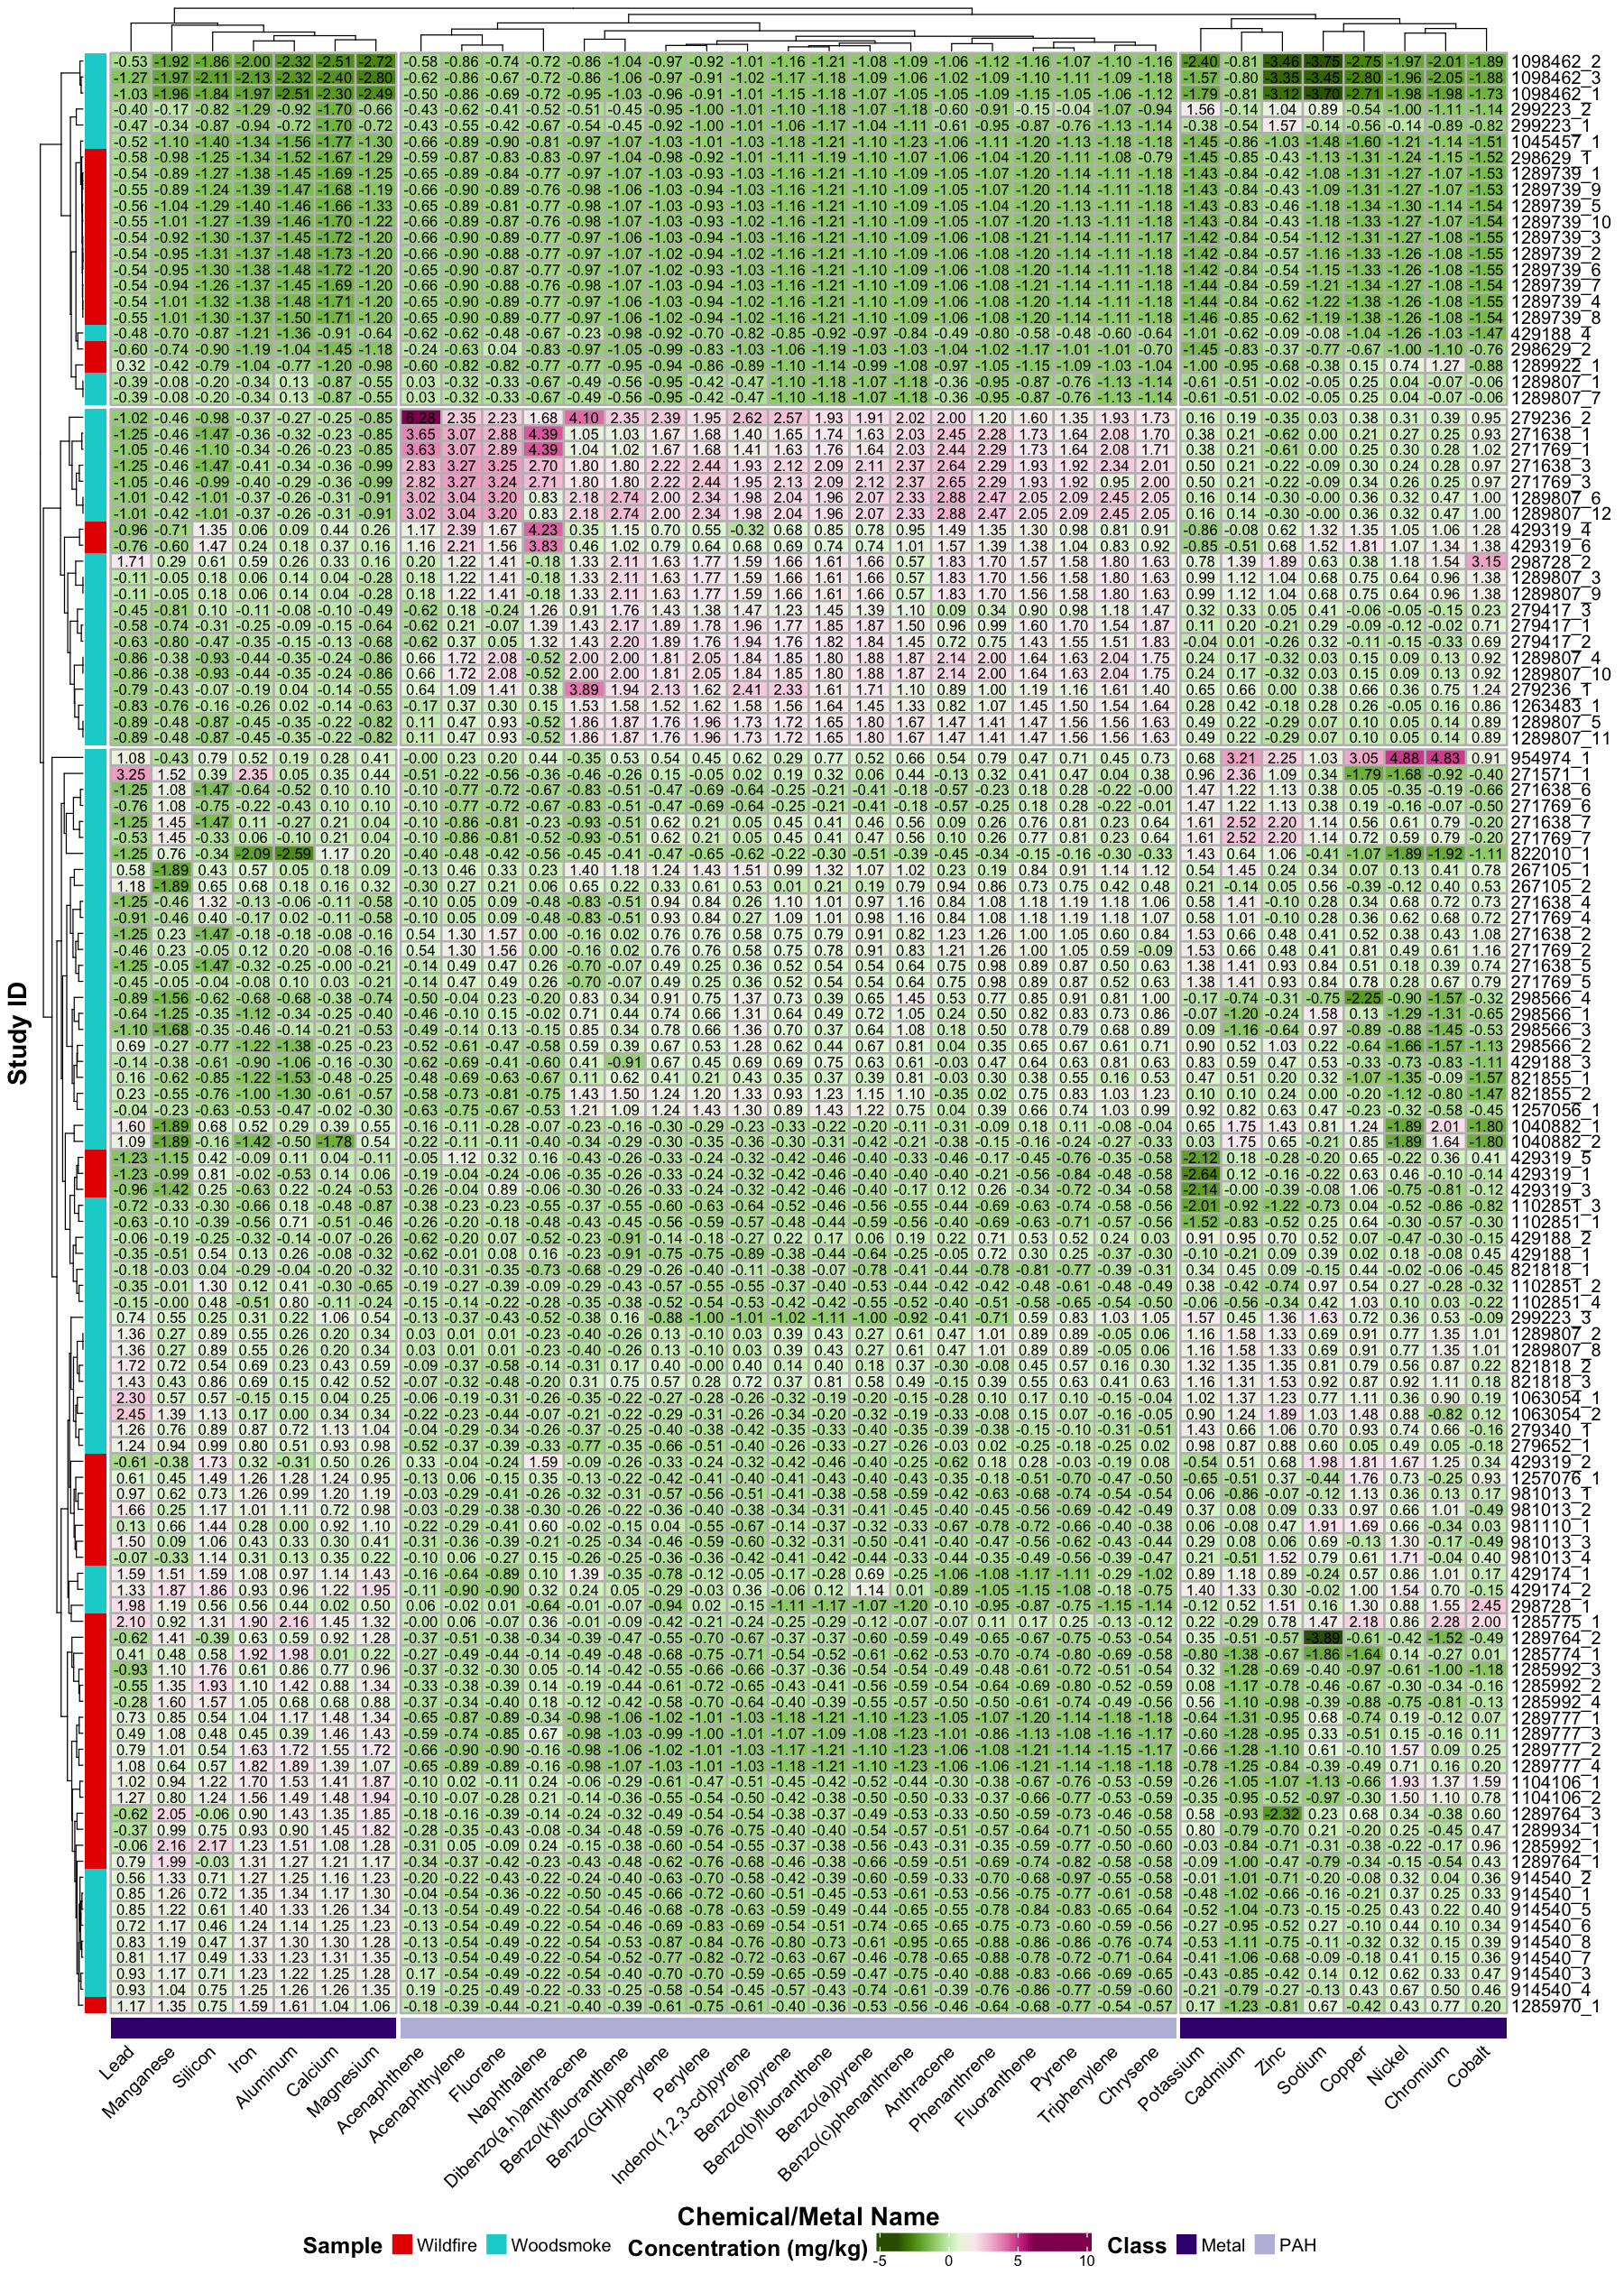

In [19]:
options(repr.plot.width=15, repr.plot.height=21) #changing size
wider_weight_df = weight_df %>%
    select(-c("DTXSID", "Class")) %>%
    # removing outliers
    filter(SampleID %notin% weight_outliers) %>%
    pivot_wider(names_from = "Name", values_from = "Value") %>%
    column_to_rownames(var = "SampleID") 

weight_map = Heatmap(scale(wider_weight_df[,6:(ncol(wider_weight_df))]), rect_gp = gpar(col = "gray", lwd = 2), # cell border color
         # legend title
         heatmap_legend_param = list(title = gt_render("Concentration (mg/kg)"),
                      title_position = "leftcenter", direction = "horizontal", legend_width = unit(5, "cm"), 
                      title_gp = gpar(fontsize = 15, fontface = "bold")),       
         # adding axes titles
         column_title = "Chemical/Metal Name", column_title_side = "bottom", 
         column_title_gp = gpar(fontsize = 17, fontface = "bold"),
         row_title = "Study ID", row_title_rot = 90,
         row_title_gp = gpar(fontsize = 17, fontface = "bold"),
         # adding in annotation (additional data)
         bottom_annotation = HeatmapAnnotation(df = annotation_weight_col_df, show_annotation_name = FALSE,
                col = list(Class = c(Metal = "#3f007d", PAH = "#bcbddc", VOC = "#9E4200")), 
                annotation_legend_param = list(title_position = "leftcenter", 
                                               grid_width = unit(0.5, "cm"), grid_height = unit(0.5, "cm"),
                                               title_gp = gpar(fontsize = 15, fontface = "bold"), nrow = 1,
                                               labels_gp = gpar(fontsize = 12))), 
         left_annotation = rowAnnotation(df = annotation_weight_row_df, show_annotation_name = FALSE,
                col = list(Sample = c(Wildfire = "#e60000", Woodsmoke = "#00d2d2")), 
                annotation_legend_param = list(title_position = "leftcenter", 
                                               grid_width = unit(0.5, "cm"), grid_height = unit(0.5, "cm"),
                                               title_gp = gpar(fontsize = 15, fontface = "bold"), nrow = 1,
                                               labels_gp = gpar(fontsize = 12))), 
         column_names_rot = 45, 
         col = fall_colors,
         # adding numbers to cells
         cell_fun = function(j, i, x, y, width, height, fill) {
         grid.text(sprintf("%.2f", scale(wider_weight_df[,6:(ncol(wider_weight_df))])[i, j]), x, y, gp = gpar(fontsize = 10))}, 
         # adds a break bewtween the largest clusters
         row_split = 3, column_split = 3)


weight_map_final = draw(weight_map, merge_legend = TRUE, heatmap_legend_side = "bottom", 
    annotation_legend_side = "bottom")
weight_map_final

## Top Metal or Chemical Contributors to PCA

In [20]:
# setting seed for reproducibility
set.seed(12)

# running pca 
vol_pca = prcomp(wider_vol_df[,c(6:ncol(wider_vol_df))], center = TRUE, scale = TRUE)
weight_pca = prcomp(wider_weight_df[,c(6:ncol(wider_weight_df))], center = TRUE, scale = TRUE)

In [21]:
# extracting chemical/metal contributions
get_contributions = function(pca_object, class){
    # ADD WORDS

    # get pca object that contains contributions
    get_pca = get_pca_var(pca_object)
    contrib_df = data.frame(get_pca$cos2)
    
    contrib_vector = c()
    for (i in 1:length(contrib_df$Dim.1)){
        
    contrib = ((get_pca$cos2[i,1] + get_pca$cos2[i,2]) * 100)/(sum(get_pca$cos2[,1]) + sum(get_pca$cos2[,2]))
    contrib_vector = c(contrib_vector, contrib)
        
    }
    
    contrib_df = data.frame(Variable = rownames(get_pca$cos2), Contribution = contrib_vector) %>%
        arrange(-Contribution) %>%
        # creating a new col to dictate colors
        mutate(Significance = ifelse(Contribution > mean(Contribution), "Yes", "No"))

    return(contrib_df)
}

# calling fn
vol_contrib_df = get_contributions(vol_pca)
weight_contrib_df = get_contributions(weight_pca)

head(vol_contrib_df)

Variable               Contribution Significance
1 Benzo(a)pyrene         4.299543     Yes         
2 Phenanthrene           4.279679     Yes         
3 Benzo(b)fluoranthene   4.271849     Yes         
4 Dibenzo(a,h)anthracene 4.268187     Yes         
5 Cobalt                 4.262817     Yes         
6 Benzo(GHI)perylene     4.260991     Yes

In [22]:
options(repr.plot.width=8, repr.plot.height=7) #changing size
vol_contrib = ggplot(vol_contrib_df, aes(x = Contribution, y = reorder(Variable, Contribution))) + 
  geom_col(aes(fill = Significance)) + 
  geom_vline(xintercept = mean(vol_contrib_df$Contribution), linetype = "dashed", color = "red") + 
  geom_text(aes(x = Contribution + 0.3, label = paste(round(Contribution, 1), "%")), fontface = "bold", size = 4.5) + 

  theme_minimal() + 
  theme(legend.position = "none", # removing legend
      axis.line = element_line(colour="black"), #making x and y axes black
      axis.text = element_text(size = 13), #changing size of x axis labels
      axis.title = element_text(face = "bold", size = rel(1.7))) + #changes axis titles

  labs(x = 'Contribution (%)', y = 'Name') + #changing axis labels 

  scale_fill_manual(values = c('Gray', "Steelblue"))

vol_contrib

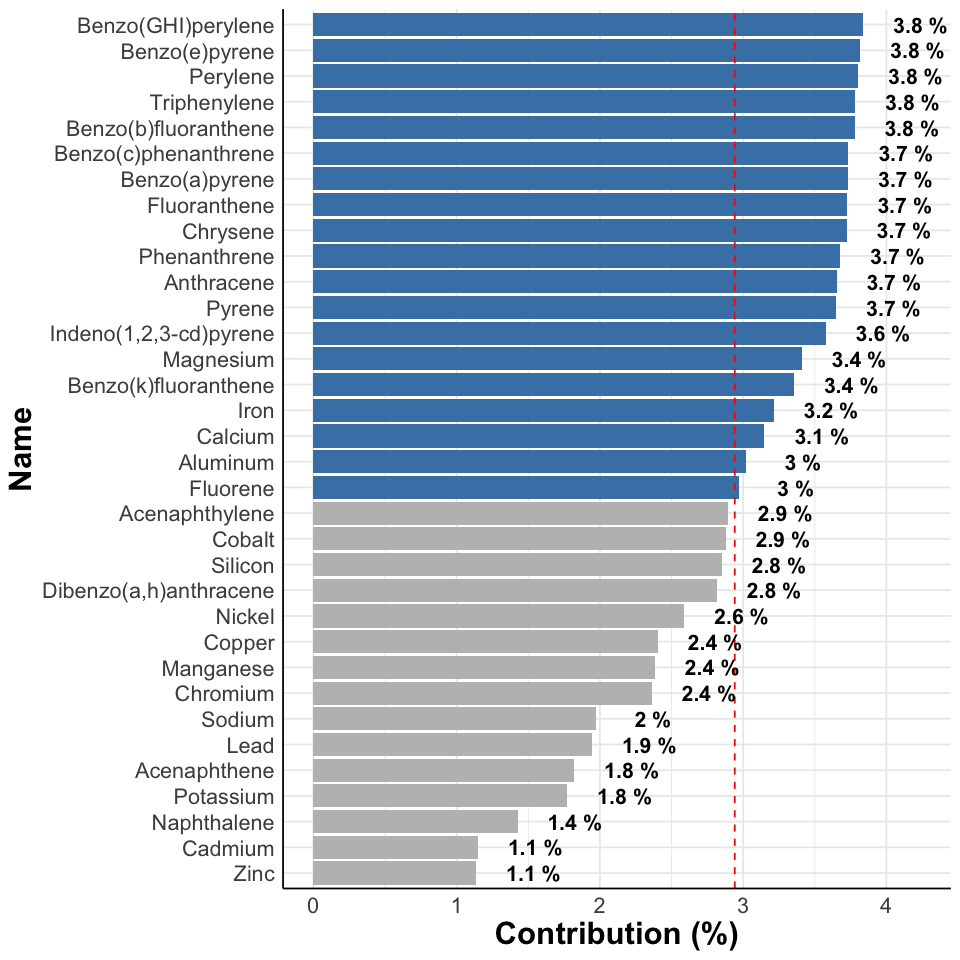

In [23]:
options(repr.plot.width=8, repr.plot.height=8) #changing size
weight_contrib = ggplot(weight_contrib_df, aes(x = Contribution, y = reorder(Variable, Contribution))) + 
  geom_col(aes(fill = Significance)) + 
  geom_vline(xintercept = mean(weight_contrib_df$Contribution), linetype = "dashed", color = "red") + 
  geom_text(aes(x = Contribution + 0.4, label = paste(round(Contribution, 1), "%")), 
            fontface = "bold", size = 4.5) + 

  theme_minimal() + 
  theme(legend.position = "none", # removing legend
      axis.line = element_line(colour="black"), #making x and y axes black
      axis.text = element_text(size = 13), #changing size of x axis labels
      axis.title = element_text(face = "bold", size = rel(1.7))) + #changes axis titles

  labs(x = 'Contribution (%)', y = 'Name') + #changing axis labels 

  scale_fill_manual(values = c('Gray', "Steelblue"))

weight_contrib

In [24]:
# # exporting figures
# ggsave(metal_vol_contrib, 
#        filename = 'metalvol.jpeg',
#        path = Output,
#        # need to respecify dimensions here when exporting figures
#        width = 8, height = 5)
# ggsave(pah_vol_contrib, 
#        filename = 'pahvol.jpeg',
#        path = Output,
#        # need to respecify dimensions here when exporting figures
#        width = 8, height = 6)
# ggsave(voc_vol_contrib, 
#        filename = 'vocvol.jpeg',
#        path = Output,
#        # need to respecify dimensions here when exporting figures
#        width = 10, height = 5)
# ggsave(metal_weight_contrib, 
#        filename = 'metalweight.jpeg',
#        path = Output,
#        # need to respecify dimensions here when exporting figures
#        width = 8, height = 5)
# ggsave(pah_weight_contrib, 
#        filename = 'pahweight.jpeg',
#        path = Output,
#        # need to respecify dimensions here when exporting figures
#        width = 8, height = 6)